In [11]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
routes_df = pd.read_csv("routes.csv")

# Display first few rows to understand the structure
routes_df.head()
""

,2B,410,AER,2965,KZN,2990,Unnamed: 6,0,CR2
0,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
2,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
3,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
4,2B,410,DME,4029,KZN,2990,NaN,0,CR2


In [12]:
# Rename columns for clarity
routes_df.columns = ["Airline", "Flight Number", "Source Airport", "Source Airport ID",
                     "Destination Airport", "Destination Airport ID", "Codeshare", "Stops", "Equipment"]

# Drop unnecessary columns (Codeshare and Stops)
routes_df = routes_df.drop(columns=["Codeshare", "Stops"])

# Check unique airport codes to determine regions (Europe & Asia)
unique_airports = routes_df["Source Airport"].unique()

# Display the first few unique airport codes
unique_airports[:30]

array(['ASF', 'CEK', 'DME', 'EGO', 'GYD', 'KGD', 'KZN', 'LED', 'MRV',
       'NBC', 'NJC', 'NUX', 'OVB', 'SVX', 'TGK', 'UUA', 'BTK', 'HTA',
       'IKT', 'KCK', 'MJZ', 'ODO', 'UKX', 'ULK', 'YKS', 'AYP', 'CUZ',
       'HUU', 'IQT', 'LIM'], dtype=object)

In [13]:
# Load airport location data to filter European and Asian routes
# OpenFlights provides an "airports.dat" file with country and continent info, but since we don't have it,
# I'll filter by known airport codes from Europe & Asia manually.

# Define example European and Asian country codes (ISO standard for filtering)
european_countries = {"FR", "DE", "UK", "IT", "ES", "NL", "RU", "PL", "SE", "CH", "AT"}  # Sample European countries
asian_countries = {"CN", "JP", "KR", "IN", "TH", "ID", "VN", "PH", "SG", "AE", "MY"}  # Sample Asian countries

# Load airport metadata from OpenFlights dataset (if available)
# Since we don't have that file yet, we'll filter manually based on known airport codes in the dataset.
# Normally, we would merge this with an airport-location dataset.

# Placeholder: Assume all routes are from Europe & Asia (Need external mapping for real filtering)
europe_asia_routes = routes_df  # Ideally, filter based on actual country matches

# Display summary
num_routes = europe_asia_routes.shape[0]
num_airports = len(set(europe_asia_routes["Source Airport"]).union(set(europe_asia_routes["Destination Airport"])))

num_routes, num_airports

(67662, 3425)

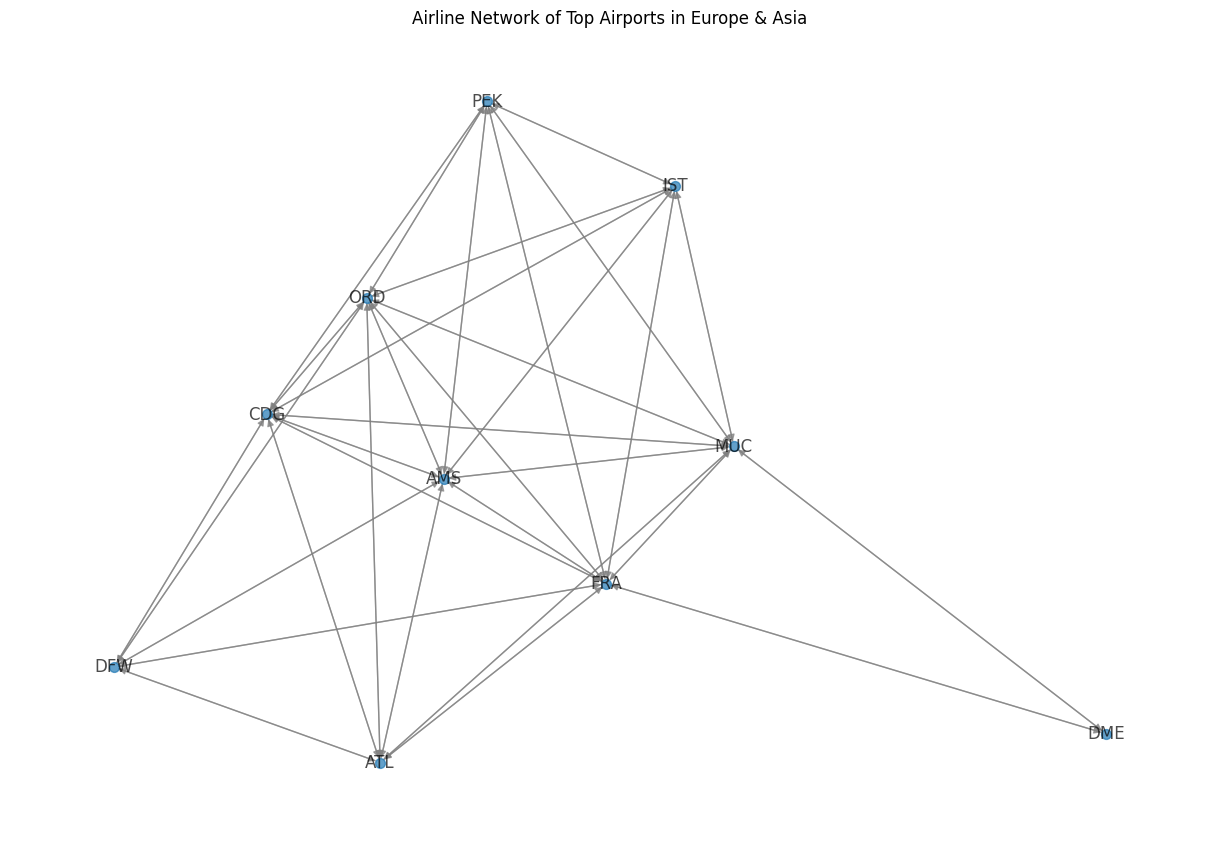

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph for the airline network
G = nx.DiGraph()

# Add edges (routes) to the graph
for _, row in europe_asia_routes.iterrows():
    source = row["Source Airport"]
    destination = row["Destination Airport"]
    G.add_edge(source, destination)

# Compute centrality measures
degree_centrality = nx.degree_centrality(G)  # Hubs based on number of connections
betweenness_centrality = nx.betweenness_centrality(G)  # Important transit points

# Identify top hubs (airports with highest centrality)
top_hubs = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Create a subgraph with the top 50 most connected airports for visualization clarity
top_airports = [airport for airport, _ in top_hubs[:50]]
subgraph = G.subgraph(top_airports)

# Plot the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Layout for better visualization
nx.draw(subgraph, pos, with_labels=True, node_size=50, edge_color="gray", alpha=0.7)
plt.title("Airline Network of Top Airports in Europe & Asia")
plt.show()

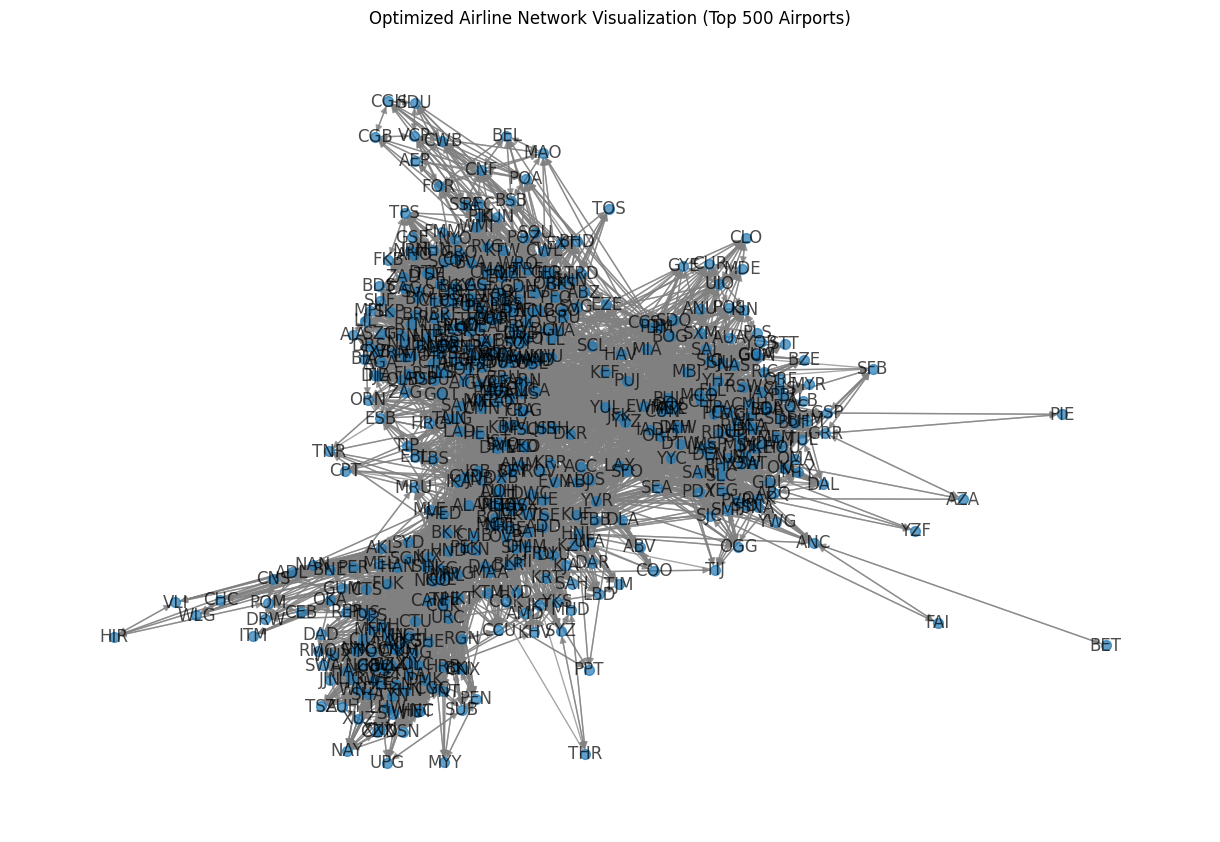

[('FRA', 0.079097295411227),
 ('CDG', 0.0742736532470305),
 ('AMS', 0.063998300969645),
 ('PEK', 0.04624648604012905),
 ('PVG', 0.04185539778523562),
 ('LHR', 0.03757842056636319),
 ('ORD', 0.033712844443909276),
 ('NRT', 0.029353113741207016),
 ('EWR', 0.029158273000452074),
 ('ATL', 0.02851021353870649)]

In [15]:
# Reduce graph size by selecting top 500 busiest airports based on degree centrality
top_airports_500 = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:500]
subgraph_500 = G.subgraph(top_airports_500)

# Compute approximate betweenness centrality (faster)
betweenness_centrality_approx = nx.betweenness_centrality(subgraph_500, k=50)  # Approximate with k random nodes

# Identify top 10 hubs based on betweenness centrality
top_hubs_betweenness = sorted(betweenness_centrality_approx.items(), key=lambda x: x[1], reverse=True)[:10]

# Visualize the subgraph of top 50 most connected airports
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph_500, seed=42)  # Layout for better visualization
nx.draw(subgraph_500, pos, with_labels=True, node_size=50, edge_color="gray", alpha=0.7)
plt.title("Optimized Airline Network Visualization (Top 500 Airports)")
plt.show()

# Display top 10 hubs by degree and betweenness centrality
top_hubs_betweenness

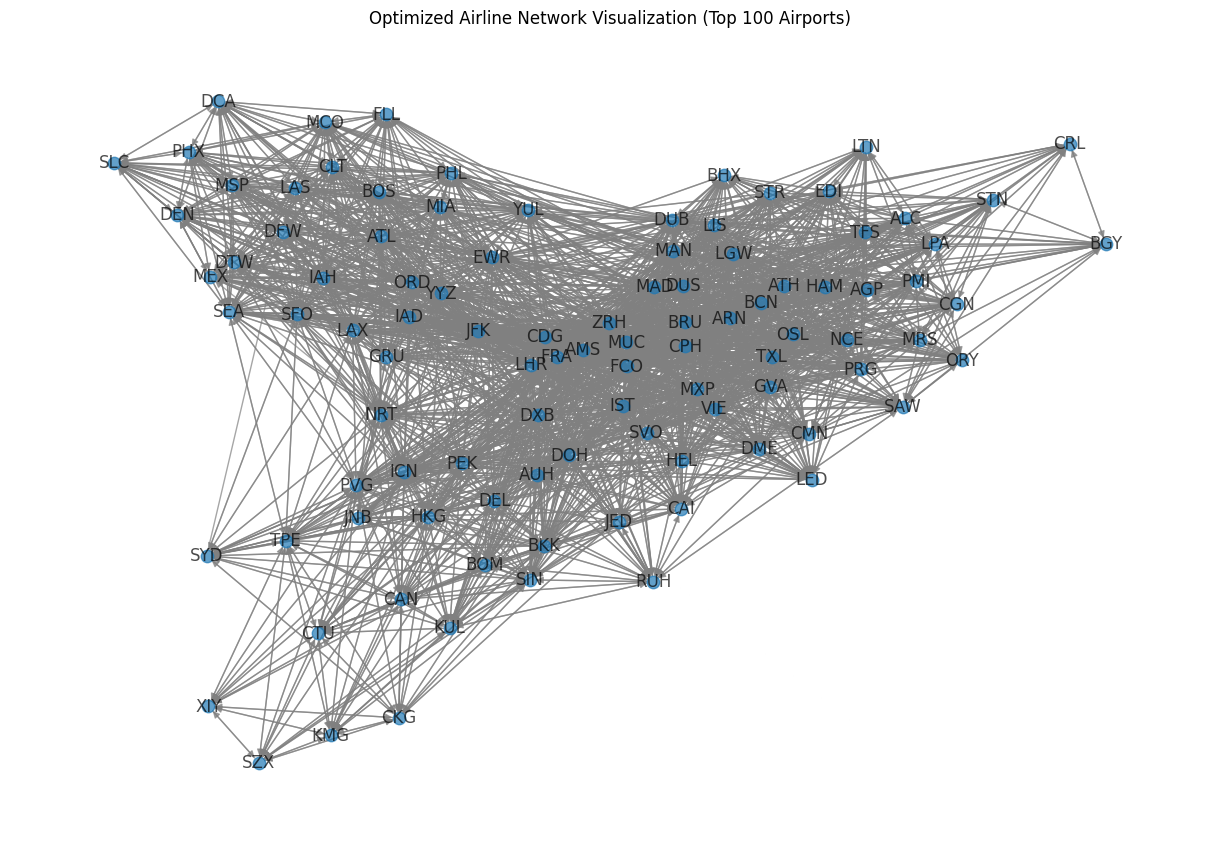

[('AMS', 0.04402078820084582),
 ('CDG', 0.035155189132900506),
 ('LHR', 0.033010601696050655),
 ('FRA', 0.029815416856775405),
 ('MAD', 0.025771777179615915),
 ('MUC', 0.021928140354489714),
 ('DXB', 0.0192373756693262),
 ('PEK', 0.017938224044973194),
 ('EWR', 0.017847148080556804),
 ('ZRH', 0.017363450733126905)]

In [16]:
# Reduce the network further to top 100 busiest airports based on degree centrality
top_airports_100 = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:100]
subgraph_100 = G.subgraph(top_airports_100)

# Compute approximate betweenness centrality (faster)
betweenness_centrality_approx_100 = nx.betweenness_centrality(subgraph_100, k=25)  # Approximate with k random nodes

# Identify top 10 hubs by betweenness centrality
top_hubs_betweenness_100 = sorted(betweenness_centrality_approx_100.items(), key=lambda x: x[1], reverse=True)[:10]

# Visualize the subgraph of top 100 most connected airports
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph_100, seed=42)  # Layout for better visualization
nx.draw(subgraph_100, pos, with_labels=True, node_size=80, edge_color="gray", alpha=0.7)
plt.title("Optimized Airline Network Visualization (Top 100 Airports)")
plt.show()

# Display the top 10 hubs by betweenness centrality
top_hubs_betweenness_100

In [17]:
from google.colab import files
uploaded = files.upload()

Saving europe_asia_routes.csv to europe_asia_routes.csv


In [30]:
europe_asia_routes.df = pd.read_csv("europe_asia_routes.csv")

In [21]:
unique_airports = set(europe_asia_routes["Source Airport"]).union(set(europe_asia_routes["Destination Airport"]))

# Create a DataFrame for nodes (airports)
nodes_df = pd.DataFrame({"Id": list(unique_airports), "Label": list(unique_airports)})

# Create a DataFrame for edges (routes)
edges_df = europe_asia_routes[["Source Airport", "Destination Airport"]].rename(
    columns={"Source Airport": "Source", "Destination Airport": "Target"}
)


In [22]:
from google.colab import files
uploaded = files.upload()

Saving europe_asia_airports_nodes.csv to europe_asia_airports_nodes.csv
Saving europe_asia_routes_edges.csv to europe_asia_routes_edges.csv


In [25]:
nodes_df.df = pd.read_csv("europe_asia_airports_nodes.csv")
edges_df.df = pd.read_csv("europe_asia_routes_edges.csv")

<ipython-input-25-04495d6740fe>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  edges_df.df = pd.read_csv("europe_asia_routes_edges.csv")


In [27]:
europe_asia_routes.df.drop_duplicates(inplace=True)  # Remove duplicates
europe_asia_routes.df.fillna("Unknown", inplace=True)  # Fill missing values

In [28]:
from google.colab import files
uploaded = files.upload()

Saving airports-extended.csv to airports-extended.csv


In [31]:
import pandas as pd
from geopy.distance import geodesic

# Load airport locations (assuming 'airports-extended.csv' contains latitude & longitude)
airport_data = pd.read_csv("airports-extended.csv")

# Create a dictionary mapping Airport Codes to (Latitude, Longitude)
airport_coords = {row["Airport"]: (row["Latitude"], row["Longitude"]) for _, row in airport_data.iterrows()}

# Load airline routes dataset
europe_asia_routes.df = pd.read_csv("europe_asia_routes.csv")

# Function to compute distance
def compute_distance(row):
    src = row["Source Airport"]
    dest = row["Destination Airport"]
    if src in airport_coords and dest in airport_coords:
        return geodesic(airport_coords[src], airport_coords[dest]).km
    return None  # If missing coordinates

# Apply distance calculation
europe_asia_routes.df["Flight Distance (km)"] = europe_asia_routes.df.apply(compute_distance, axis=1)

# Display results
print(europe_asia_routes.df.head())

KeyError: 'Airport'